In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lime.lime_tabular import LimeTabularExplainer

import argparse
import datetime
import random
import signal
import sys
import warnings
from collections import Counter
from functools import partial
from pathlib import Path
from types import FrameType
from typing import Any

import dill
import multiprocess
import numpy as np
import pandas as pd
import torch
from synth_xai.explanations.explanation_utils import (
    evaluate_bb,
    find_top_closest_rows,
    get_test_data,
    is_explainer_supported,
    label_synthetic_data,
    load_bb,
    load_synthetic_data,
    make_predictions,
    prepare_neighbours,
    setup_wandb,
    transform_input_data,
)
from loguru import logger
from multiprocess import Pool
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
)

from synth_xai.bb_architectures import MultiClassModel, SimpleModel
from synth_xai.explanations.explainer_model import ExplainerModel
from synth_xai.utils import (
    prepare_adult,
)

/home/lcorbucci/synth_xai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class aix_model:
    def __init__(self, model: torch.nn.Module) -> None:
        self.model = model

    def predict(self, x: np.ndarray) -> torch.Tensor:
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.nn.functional.softmax(self.model(x)).detach().numpy()


In [3]:
seed = 112
current_script_path = Path("./").resolve()

_, _, x_test, _, _, _, train_df, test_data = prepare_adult(sweep=False, seed=seed, current_path=current_script_path)


# Get the feature names after one-hot encoding
feature_names = list(train_df.drop(columns=["income_binary"]).columns)

# Identify categorical features (before one-hot encoding)
categorical_features = [
    train_df.columns.get_loc(col)
    for col in ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
    if col in train_df.columns
]

# Define the class names
class_names = ["<=50K", ">50K"]

In [4]:
# Initialize LimeTabularExplainer
explainer = LimeTabularExplainer(
    train_df.drop(columns=["income_binary"]).values,  # Unscaled training data
    mode="classification",
    feature_names=feature_names,
    categorical_features=categorical_features,
    class_names=class_names,
    discretize_continuous=True,  # Discretize continuous features for better interpretability
)

In [5]:
bb_path = "../../../artifacts/adult/bb/adult_BB.pth"
bb = load_bb(bb_path)

In [6]:
bb.to("cpu")
model = aix_model(model=bb)

In [7]:
# Define a wrapper function for prediction (LIME expects probability outputs)
def predict_fn(x):
    return model.predict_proba(x)

In [8]:
# Generate explanation
sample_idx = 4  # Choose any index from x_test
sample = x_test[sample_idx]
explanation = explainer.explain_instance(sample, predict_fn, num_features=10)
explanation.as_list()

[('race_ Black > 0.00', -0.0023360584168073927),
 ('occupation_ Sales > 0.00', -0.0017778200308074396),
 ('relationship_ Own-child > 0.00', -0.0013895801602106695),
 ('education_ Bachelors > 0.00', -0.001265049323201768),
 ('fnlwgt <= 117627.75', -0.000871996831046423),
 ('native-country_ Ireland <= 0.00', -0.000844212313454104),
 ('age <= 28.00', -0.0008435032012465599),
 ('native-country_ Honduras <= 0.00', 0.0007137728935998556),
 ('native-country_ Jamaica <= 0.00', -0.000538104501036255),
 ('native-country_ Portugal <= 0.00', -0.0004994773366007075)]

In [9]:
explanation.local_pred

array([0.99263379])

# Shap

In [86]:
from pathlib import Path

import numpy as np
import torch
import shap

from synth_xai.bb_architectures import MultiClassModel, SimpleModel
from synth_xai.explanations.explanation_utils import load_bb
from synth_xai.utils import prepare_adult
from sklearn.cluster import KMeans

In [108]:
np.empty((0,2))

array([], shape=(0, 2), dtype=float64)

In [106]:
def get_representative_samples(dataset,samples_per_class=5):
    '''this function is used to get the representative samples of the dataset. but in a different way.
    First there is a clustering of all the data. The best k is retrieved using the elbow method.
    Then, for each cluster we order the samples by the distance from the centroid in 4 bins.
    Then we take some samples of each bin as the representative sample of the cluster, (in order to have the label)'''
    # print(dataset.tensors[1].shape,"shape of the labels")
    num_classes = 2
    representative_samples = np.empty((0,dataset.shape[1]))
    labels = np.empty((0,num_classes))
    # create the kmeans object
    inertias = []
    max_K = min(12,dataset.shape[0])
    for i in range(2,max_K):
        kmeans = KMeans(n_clusters=i, random_state=42,n_init=3)
        kmeans.fit(dataset)
        # get the centroids of the clusters
        inertias.append(kmeans.inertia_)

    # coupute the best k
    inertias_diff = np.diff(inertias)
    # find the last highest difference
    k = inertias_diff[::-1].argmax()
    k = len(inertias) - k
    print("best k:",k)
    # plot the elbow plot

    kmeans = KMeans(n_clusters=k, random_state=42,n_init=3)
    kmeans.fit(dataset)
    # get the centroids of the clusters
    centroids = kmeans.cluster_centers_
    # get the samples that are mapped to each cluster
    labels = kmeans.labels_
    representative_labels = np.empty((0,num_classes))
    for cluster in range(k):
        # get the samples of the cluster
        cluster_samples = dataset[labels==cluster,:]
        # get the distances of the samples from the centroid
        distances = np.linalg.norm(cluster_samples-centroids[cluster],axis=1)
        # order the samples in 4 bins using again KMeans, but on the distances
        kkkk = min(4,cluster_samples.shape[0])
        kmeans = KMeans(n_clusters=kkkk, random_state=42,n_init=3)
        kmeans.fit(distances.reshape(-1,1))
        ordered_samples = cluster_samples[np.argsort(kmeans.labels_)]

        
        # divide the samples in 4 bins
        bins = [ordered_samples[kmeans.labels_==i] for i in range(4)]
        # plot the number of samples in each bin
    
        original_labels_of_cluster = dataset[labels==cluster,:]
        print(original_labels_of_cluster)
        
                                            
        # take the first sample of each bin, and its relative label
        for d_i in range(4):
            # if there are no samples in the bin, skip it
            if len(bins[d_i]) == 0:
                continue
            # choose a random sample from the bin
            rnd_sample = 0#np.random.choice(bins[d_i])
            representative_samples = np.vstack((representative_samples,bins[d_i][rnd_sample]))
            print(original_labels_of_cluster[rnd_sample,:])
            print(representative_labels)
            representative_labels = np.vstack([representative_labels,
                                                original_labels_of_cluster[rnd_sample,:]])
                                    
    print(representative_samples.shape,representative_labels.shape)
    return representative_samples,representative_labels

In [107]:
feats, labs = get_representative_samples(x_train[0:40], samples_per_class=30//num_classes)

best k: 9
[0.5890411  0.07921846 0.6        0.         0.         0.39795918
 1.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 111

In [88]:
class aix_model:
    def __init__(self, model: torch.nn.Module) -> None:
        self.model = model

    def predict(self, x: np.ndarray) -> torch.Tensor:
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        x = torch.Tensor(x)
        return torch.nn.functional.softmax(self.model(x), dim=1).detach().numpy()

In [89]:
seed = 112
current_script_path = Path("./").resolve()
print(current_script_path)
x_train, _, x_test, _, _, _, train_df, test_data = prepare_adult(sweep=False, seed=seed, current_path=current_script_path)

/home/lcorbucci/synth_xai/src/synth_xai/comparison


In [90]:

# Get the feature names after one-hot encoding
feature_names = list(train_df.drop(columns=["income_binary"]).columns)


In [91]:
bb_path = "../../../artifacts/adult/bb/adult_BB.pth"
bb = load_bb(bb_path)

bb.to("cpu")
model = aix_model(model=bb)

In [92]:
num_classes = 2

In [79]:
# Define SHAP explainer
# explainer = shap.Explainer(model.predict_proba, x_test)
explainer = shap.KernelExplainer(model.predict_proba, data=shap.kmeans(x_test, 20))

In [ ]:

# Generate explanation
sample_idx = 4  # Choose any index from x_test
sample = x_test[sample_idx:sample_idx+1]  # Keep sample as a batch
shap_values = explainer(sample)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


In [81]:
predicted_class = model.predict(sample)
predicted_class = predicted_class.item()
predicted_class

0

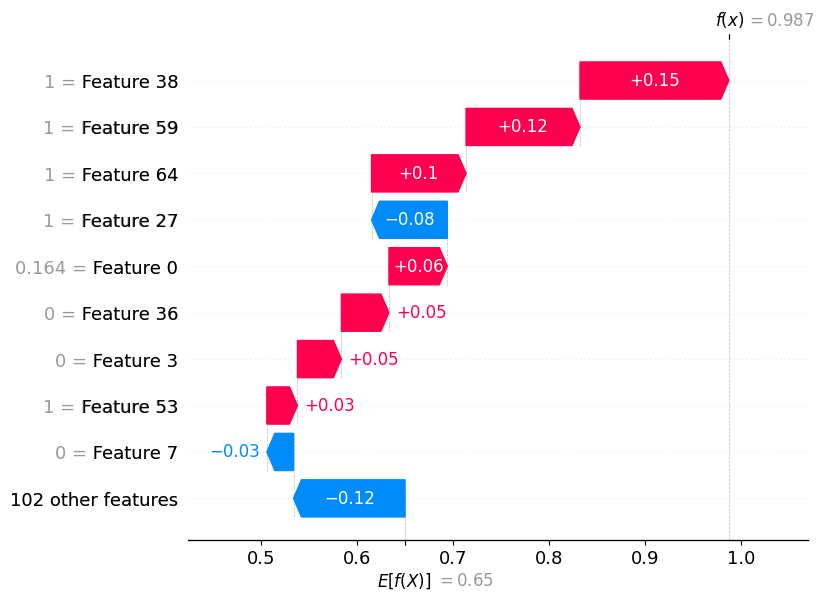

In [ ]:
shap.plots.waterfall(shap_values[0,:,predicted_class])

In [83]:
shap_values[0,:,predicted_class].values

array([ 0.06075911, -0.02544865, -0.00828133,  0.0457333 ,  0.00778318,
        0.00702685,  0.00100019, -0.02775292, -0.00637734, -0.00107813,
        0.        ,  0.        ,  0.        ,  0.00652327,  0.        ,
        0.00069853,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.07884485,  0.        , -0.010478  ,
        0.        ,  0.        ,  0.        , -0.00292717, -0.01855544,
        0.        ,  0.04947725,  0.        ,  0.15491603,  0.        ,
        0.        , -0.00236853,  0.        ,  0.        ,  0.        ,
        0.00341925,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00436803,  0.        ,  0.03184863,  0.        ,
        0.        , -0.01305926, -0.00509286,  0.        ,  0.11856886,
       -0.00561667,  0.00226586,  0.        ,  0.        ,  0.09834321,
        0.        , -0.02689701, -0.02634982,  0.00338757,  0.  